retrieving "D:\projects\car-license-plate-recognition\doc\problem\placas\141002\Pa140028.jpg.pkz"


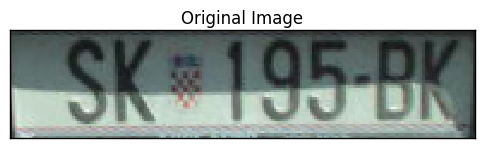

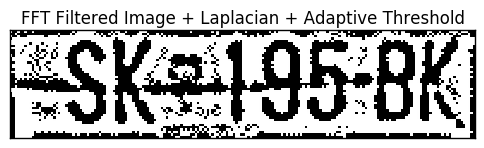

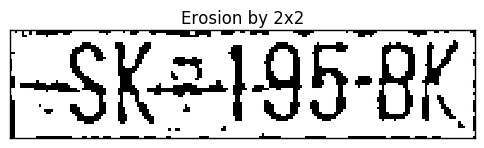

In [41]:
% matplotlib inline

import os
import cv2
import matplotlib.pyplot as plt
from plate import detect, segment, noise, roi, binarization
import numpy as np

# img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\141002\\Pa140022.jpg"
# img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\141002\\Pa140015.jpg"
img_path = "D:\\projects\\car-license-plate-recognition\\doc\\problem\\placas\\141002\\Pa140028.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# plate points retrieving
points = []
points_path = img_path + '.pkz'
if os.path.exists(points_path):
    points = roi.retrieve(points_path, decompress=False)
else:
    print(img_path, ' points file for plate not found')
    exit(1)

# plate segmentation
plates = segment.segment_plates(img, [points])
gray = cv2.cvtColor(plates[0], cv2.COLOR_RGB2GRAY)
h, w = gray.shape

# noise filtering
mask = np.zeros((h, w), np.float32)
cv2.ellipse(mask, center=(w >> 1, h >> 1), axes=(w >> 2, h >> 2), angle=0, startAngle=0, endAngle=360, color=255,
            thickness=-1)
mask = cv2.blur(mask, (5, 5), borderType=cv2.BORDER_REPLICATE)
mask = cv2.normalize(mask, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
filtered = noise.fft_filter(gray, mask)

plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.imshow(plates[0], interpolation='none')
plt.show()

# binarization
window_size = ((h>>1)<<1)+1
gx = int(window_size/5)
gy = int(window_size/5)
filtered_blurred = cv2.GaussianBlur(filtered, (gx, gy), 0)
img_back_gray_filtered = cv2.Laplacian(filtered_blurred, cv2.CV_64F)
img_back_gray_filtered = cv2.normalize(img_back_gray_filtered, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)

img_bin = cv2.adaptiveThreshold(img_back_gray_filtered, 255, cv2.THRESH_BINARY_INV, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, window_size, 0)
plt.imshow(img_bin, cmap = 'gray', interpolation='none')
plt.title('FFT Filtered Image + Laplacian + Adaptive Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

img_bin = cv2.dilate(img_bin, cv2.getStructuringElement(cv2.MORPH_ERODE, (2, 2)), iterations=1)
# img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4)))
plt.title('Erosion by 2x2'), plt.xticks([]), plt.yticks([])
plt.imshow(img_bin, cmap='gray', interpolation='none')
plt.show()

# img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))
# plt.title('Closing by 3x3'), plt.xticks([]), plt.yticks([])
# plt.imshow(img_bin, cmap='gray', interpolation='none')
# plt.show()